In [1]:
# from /Users/johnbarrera/Documents/Projects/world_bank/Climate-and-Disaster-Risk-Management-for-Health-Systems/src/utils/geo_objects.py import TiffReader

In [2]:
import os
import sys

In [3]:
import pandas as pd
import numpy as np
import shapefile as shp
import osmnx as ox
import contextily as ctx
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D  # for legend handle
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics.pairwise import haversine_distances
from shapely.geometry import Point
from pyproj import Proj, transform
import math
from matplotlib.colors import Normalize

# sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "../src"))
# import functions_support as fsupport

import importlib

# importlib.reload(fsupport)

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import hashlib
from datetime import datetime, timedelta

In [4]:
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "/Users/johnbarrera/Documents/Projects/world_bank/Climate-and-Disaster-Risk-Management-for-Health-Systems"))


In [5]:
import rasterio
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import geopandas as gpd
from tqdm import tqdm

In [6]:
input_path = "../data/nepal/inputs/pga_475y.tif"
input_path2 = "../data/nepal/inputs/pga_specifications.xlsx"
output_path = "../data/nepal/outputs/map/Peak_Ground_Acceleration.gpkg"


In [7]:
# Abre el archivo TIF
with rasterio.open(input_path) as src:
    # Imprime información sobre el archivo
    print(src.profile)

    # Lee todas las bandas y guarda los valores en una matriz
    data = src.read()

    # Imprime el número de bandas y el tamaño de la matriz
    print(f'Número de bandas: {src.count}')
    print(f'Tamaño de la matriz: {data.shape}')



{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 721, 'height': 361, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.5, 0.0, -180.25,
       0.0, -0.5, 90.25), 'blockysize': 2, 'tiled': False, 'interleave': 'band'}
Número de bandas: 1
Tamaño de la matriz: (1, 361, 721)


In [8]:
# Definir una función para transformar las coordenadas de los píxeles a coordenadas de mapa
def pixel_to_map_coordinates(transform, col, row):
    x, y = transform * (col, row)
    return x, y

# Abrir el archivo TIF
with rasterio.open(input_path) as src:
    # Leer todas las bandas y guardar los valores en una matriz
    data = src.read()

    # Obtener la transformación de coordenadas de píxeles a coordenadas de mapa
    transform = src.transform

    # Crear una lista vacía para almacenar los datos de cada polígono
    polygons = []

    # Iterar sobre cada banda y crear polígonos para cada píxel con valor distinto de cero
    for i in range(src.count):
        band_data = data[i, :, :]

        for row in tqdm(range(band_data.shape[0])):
            for col in range(band_data.shape[1]):
                # Obtener el valor del píxel
                value = band_data[row, col]

                # Si el valor es cero, ignorar el píxel
                if value > 0:
                    #continue

                    # Calcular las coordenadas de los cuatro vértices del polígono
                    x1, y1 = pixel_to_map_coordinates(transform, col, row)
                    x2, y2 = pixel_to_map_coordinates(transform, col + 1, row)
                    x3, y3 = pixel_to_map_coordinates(transform, col + 1, row + 1)
                    x4, y4 = pixel_to_map_coordinates(transform, col, row + 1)

                    # Crear el polígono a partir de los vértices
                    poly = Polygon([(x1, y1), (x2, y2), (x3, y3), (x4, y4)])

                    # Agregar el polígono y su información a la lista de polígonos
                    polygon_data = {
                        'band': i+1,
                        'value': value,
                        'geometry': poly
                    }
                    polygons.append(polygon_data)
                    
# Crear un GeoDataFrame a partir de la lista de polígonos
gdf = gpd.GeoDataFrame(polygons)


100%|██████████| 361/361 [00:02<00:00, 164.30it/s]


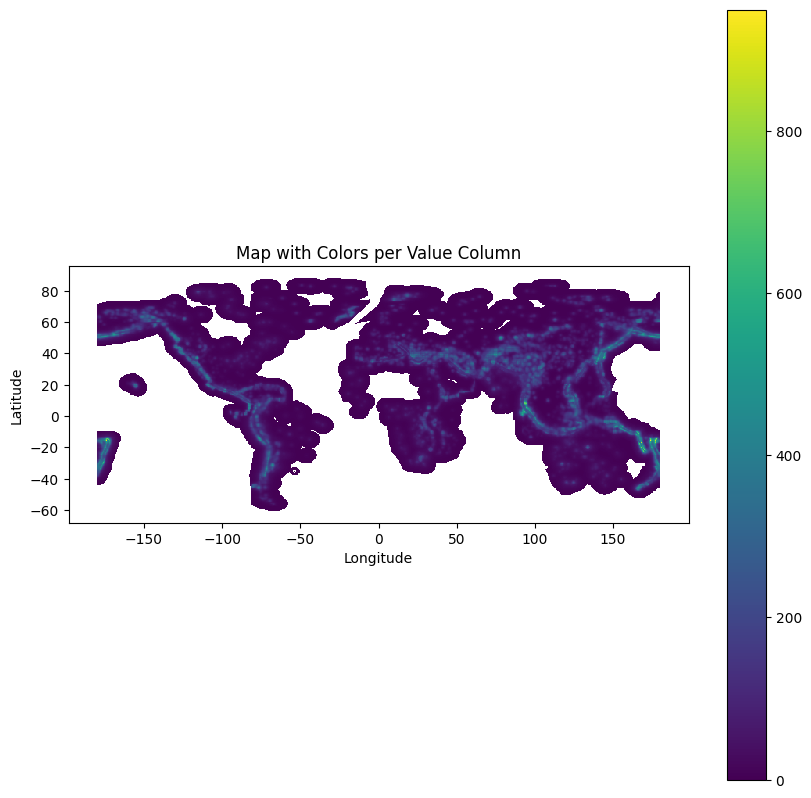

In [9]:
# Plot the GeoDataFrame with colors based on the 'value' column
gdf.plot(column='value', cmap='viridis', legend=True, figsize=(10, 10))

# Add title and labels
plt.title('Map with Colors per Value Column')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [10]:

pga_specifications = pd.read_excel(f"{input_path2}")  

# dtype_mapping = {
#     'Acceleration_min': float,
#     'Acceleration_max': float, 
# }

# pga_specifications = pd.read_csv(f"{input_path2}", dtype=dtype_mapping)
pga_specifications

,Instrumental_Intensity,Acceleration_g,Acceleration_min,Acceleration_max,Velocity_cmxs,Perceived_shaking,Potential_damage
0,I,< 0.000464,-1.000000,0.000464,< 0.0215,Not felt,NaN
1,II–III,0.000464 – 0.00297,0.000464,0.002970,0.135 – 1.41,Weak,NaN
2,IV,0.00297 – 0.0276,0.002970,0.027600,1.41 – 4.65,Light,NaN
3,V,0.0276 – 0.115,0.027600,0.115000,4.65 – 9.64,Moderate,Very light
4,VI,0.115 – 0.215,0.115000,0.215000,9.64 – 20,Strong,Light
5,VII,0.215 – 0.401,0.215000,0.401000,20 – 41.4,Very strong,Moderate
6,VIII,0.401 – 0.747,0.401000,0.747000,41.4 – 85.8,Severe,Moderate to heavy
7,IX,0.747 – 1.39,0.747000,1.390000,85.8 – 178,Violent,Heavy
8,X+,> 1.39,1.390000,9999.000000,> 178,Extreme,Very heavy


In [11]:
gdf

,band,value,geometry
0,1,0.130796,"POLYGON ((-53.75000 88.25000, -53.25000 88.250..."
1,1,0.189906,"POLYGON ((-53.25000 88.25000, -52.75000 88.250..."
2,1,0.214620,"POLYGON ((-52.75000 88.25000, -52.25000 88.250..."
3,1,0.234616,"POLYGON ((-52.25000 88.25000, -51.75000 88.250..."
4,1,0.262942,"POLYGON ((-51.75000 88.25000, -51.25000 88.250..."
...,...,...,...
117885,1,0.284648,"POLYGON ((-65.75000 -60.25000, -65.25000 -60.2..."
117886,1,0.279299,"POLYGON ((-65.25000 -60.25000, -64.75000 -60.2..."
117887,1,0.251764,"POLYGON ((-64.75000 -60.25000, -64.25000 -60.2..."
117888,1,0.226035,"POLYGON ((-64.25000 -60.25000, -63.75000 -60.2..."


In [12]:
def identify_interval(value, df, min_col, max_col):
    for index, row in df.iterrows():
        min_value = row[min_col]
        max_value = row[max_col]
        if min_value <= value and value < max_value:
            return row['Instrumental_Intensity'], row['Acceleration_g'], row['Velocity_cmxs'], row['Perceived_shaking'], row['Potential_damage']
        

def gdf_interval_df(gdf, df, value_col, min_col, max_col):
    '''
    '''
    gdf2 = gdf.copy()
    resultado = gdf2.apply(lambda x: identify_interval(x[value_col], df, min_col, max_col), axis=1)
    gdf2['Instrumental_Intensity'] = [x[0] for x in resultado]
    gdf2['Acceleration_g'] = [x[1] for x in resultado]
    gdf2['Velocity_cmxs'] = [x[2] for x in resultado]
    gdf2['Perceived_shaking'] = [x[3] for x in resultado]
    gdf2['Potential_damage'] = [x[4] for x in resultado]

    return gdf2

gdf2 = gdf_interval_df(gdf, pga_specifications, value_col='value', min_col='Acceleration_min', max_col='Acceleration_max')
gdf2

,band,value,geometry,Instrumental_Intensity,Acceleration_g,Velocity_cmxs,Perceived_shaking,Potential_damage
0,1,0.130796,"POLYGON ((-53.75000 88.25000, -53.25000 88.250...",VI,0.115 – 0.215,9.64 – 20,Strong,Light
1,1,0.189906,"POLYGON ((-53.25000 88.25000, -52.75000 88.250...",VI,0.115 – 0.215,9.64 – 20,Strong,Light
2,1,0.214620,"POLYGON ((-52.75000 88.25000, -52.25000 88.250...",VI,0.115 – 0.215,9.64 – 20,Strong,Light
3,1,0.234616,"POLYGON ((-52.25000 88.25000, -51.75000 88.250...",VII,0.215 – 0.401,20 – 41.4,Very strong,Moderate
4,1,0.262942,"POLYGON ((-51.75000 88.25000, -51.25000 88.250...",VII,0.215 – 0.401,20 – 41.4,Very strong,Moderate
...,...,...,...,...,...,...,...,...
117885,1,0.284648,"POLYGON ((-65.75000 -60.25000, -65.25000 -60.2...",VII,0.215 – 0.401,20 – 41.4,Very strong,Moderate
117886,1,0.279299,"POLYGON ((-65.25000 -60.25000, -64.75000 -60.2...",VII,0.215 – 0.401,20 – 41.4,Very strong,Moderate
117887,1,0.251764,"POLYGON ((-64.75000 -60.25000, -64.25000 -60.2...",VII,0.215 – 0.401,20 – 41.4,Very strong,Moderate
117888,1,0.226035,"POLYGON ((-64.25000 -60.25000, -63.75000 -60.2...",VII,0.215 – 0.401,20 – 41.4,Very strong,Moderate


In [13]:
gdf2.to_file(output_path, driver="GPKG")

In [14]:
set(gdf2['Instrumental_Intensity'])

{'I', 'IV', 'IX', 'V', 'VI', 'VII', 'VIII', 'X+'}